# Setting up GPU
using the Tesla T4 GPU for this project provided by google colab to enhance the training speed and help us for mixed precision training.


In [29]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-472c2fa7-bc47-a63d-d167-ba8f7a1c078c)


# Imporing helper functions
importing a script of python function to analyse the model.

In [30]:
# Downloading the helper functions
!wget https://raw.githubusercontent.com/saqibsid/Pixelicious/main/scripts/helper_functions.py

--2023-12-23 11:45:25--  https://raw.githubusercontent.com/saqibsid/Pixelicious/main/scripts/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10532 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.29K  --.-KB/s    in 0s      

2023-12-23 11:45:25 (101 MB/s) - ‘helper_functions.py.1’ saved [10532/10532]



In [31]:
# importing the neccessary functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

# Using Tensorflow Datsets to Download the Data
> `TensorFlow Dataset` is a module that provides a high-level API for efficiently managing and manipulating input data for machine learning models in TensorFlow.


In [32]:
import tensorflow_datasets as tfds

dataset_list = tfds.list_builders()
print("food101" in dataset_list) # to check if food 101 dataset is present in tensorflow datasets

True


now that we have the dataset on which we will be working on, let's load the data using `tfds.load`. It might take time to load since the size of the dataset is about 5 GB.

In [33]:
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train','validation'],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data,label)
                                             with_info=True)

In [34]:
print(ds_info)

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir='/root/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo nu

In [35]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})


# Exploring the Data

In [36]:
 # getting the class names
 class_names = ds_info.features["label"].names
 print(class_names[:10])

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [37]:
# taking one sample of our data and visualisaing it
train_one_sample = train_data.take(1) # sample one image in form (image,label)

train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [38]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 31
  Class name (str form): donuts
        


(-0.5, 511.5, 511.5, -0.5)

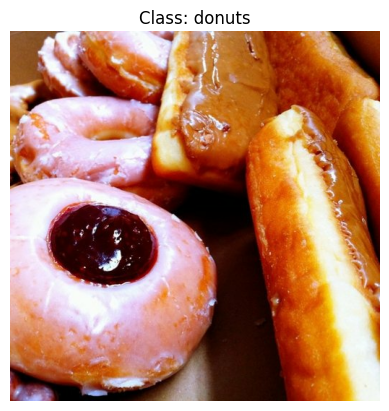

In [39]:
## plotting a random image
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(f"Class: {class_names[label]}")
plt.axis(False)

# preprocessing functions
* to convert all image size to a (224,224,3)
* to convert datatype of our image tensor from `unit8` to `float32`
* can rescale the pixel values to be between 0 and 1 but since I am using EfficientNet it already has a rescale layer.

In [40]:
import tensorflow as tf

In [41]:
def preprocess_img(image,label,img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape,img_shape,color_channels]
  """
  image = tf.image.resize(image,[img_shape,img_shape]) # reshaping the target image
  return tf.cast(image,tf.float32),label


In [42]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0] # image
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[131  86  55]
  [134  89  58]
  [137  92  61]
  ...
  [131  44   0]
  [135  49   2]
  [138  52   5]]

 [[134  89  58]
  [135  90  59]
  [135  90  59]
  ...
  [133  46   1]
  [134  48   1]
  [134  48   1]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[1.34030609e+02 8.90306168e+01 5.80306129e+01]
  [1.36045914e+02 9.10459213e+01 6.00459175e+01]
  [1.37846939e+02 9.28469391e+01 6.38469391e+01]
  ...
  [1.30265366e+02 4.79183846e+01 1.62753057e+00]
  [1.30760223e+02 4.37602272e+01 4.59267795e-02]
  [1.34739838e+02 4.87398338e+01 1.73983324e+00]]

 [[1.41551025e+02 9.65510254e+01 6.55510254e+01]
  [1.49081650e+02 1.04081635e+02 7.30816345e+01]
  [1.51632660e+02 1.06632652e+02 7.56326523e+01]
  ...
  [1.30357101e+02 4.85713654e+01 1.99989128e+00]
  [1.34147995e+02 5.01479988e+01 4.14799976e+00]
  [1.33571289e+02 4.95712891e+01 3.57128906e+00]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


In [43]:
# map the preprocessing function to training data and parallelizing it
train_data = train_data.map(map_func=preprocess_img,  num_parallel_calls=tf.data.AUTOTUNE) # mapping the function to entire train dataset and parallelizing it to reduce time

In [44]:
# shuffle the train_data and convert it to batches
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) # shuffle thousand samples at a time and convert it to batch size of 32 and


main idea is of `prefetch` to fetch the next batch of data in the background while the current batch is being processed by the model. This can lead to more efficient training and inference pipelines by reducing the idle time of the model.

In [45]:
# for the test data
test_data = test_data.map(map_func=preprocess_img,  num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [46]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# creating callbacks

In [47]:
# model checkpoint
checkpoint_path = 'model_checkpoints/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_acc',
                                                      save_best_only = True,
                                                      save_weights_only = True,
                                                      verbose=0)

# setting up mixed precision

In [48]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [49]:
mixed_precision.global_policy()

<Policy "mixed_float16">

# Build Feature Extraction Model

In [50]:
INPUT_SHAPE = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # pre-trained on imagenet
base_model.trainable = False

# create functional model
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE, name='input_layer')

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation('softmax',dtype=tf.float32, name='softmax_float32')(x)

model = tf.keras.Model(inputs,outputs)

# compile the model
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [51]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

In [52]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [53]:
# fit the feature extraction model
history_feature_extraction = model.fit(train_data,
                                       steps_per_epoch=len(train_data),
                                       validation_data = test_data,
                                       validation_steps=int(0.15*len(test_data)),
                                       epochs=3,
                                       callbacks=[create_tensorboard_callback(dir_name='training_logs',
                                                                              experiment_name='EfficientNetB0_feature_extraction'),
                                                  model_checkpoint])

Saving TensorBoard log files to: training_logs/EfficientNetB0_feature_extraction/20231223-114531
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7166 - accuracy: 0.5823

2368/2368 [==============================] - 224s 85ms/step - loss: 1.7166 - accuracy: 0.5823 - val_loss: 1.1330 - val_accuracy: 0.6981
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1987 - accuracy: 0.6887

2368/2368 [==============================] - 231s 96ms/step - loss: 1.1988 - accuracy: 0.6887 - val_loss: 1.0397 - val_accuracy: 0.7119
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0542 - accuracy: 0.7231

2368/2368 [==============================] - 189s 79ms/step - loss: 1.0542 - accuracy: 0.7231 - val_loss: 1.0087 - val_accuracy: 0.7217


In [54]:
result_feature_extraction_model = model.evaluate(test_data)

790/790 [==============================] - 58s 72ms/step - loss: 1.0018 - accuracy: 0.7270


In [55]:
# saving the model
model.save('feature_extraction_model_with_EfficientNetB0')

# fine-tuning the above model

In [56]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

In [57]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [58]:
# unfreezing some layers
base_model.trainable = True

# freeze every layer except last 5
for layer in base_model.layers[:-5]:
    layer.trainable=False

In [59]:
# recompile model
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
             optimizer= tf.keras.optimizers.Adam(lr=0.0001),
             metrics=['accuracy'])

In [60]:
history_fine_tuned = model.fit(train_data,
                        validation_data = test_data,
                        steps_per_epoch=len(train_data),
                        validation_steps = int(0.15*len(test_data)),
                        epochs=10,
                        initial_epoch = history_feature_extraction.epoch[-1],
                        callbacks=[early_stopping,reduce_lr,model_checkpoint])

Epoch 3/10
2368/2368 [==============================] - ETA: 0s - loss: 1.1968 - accuracy: 0.6822

2368/2368 [==============================] - 202s 80ms/step - loss: 1.1968 - accuracy: 0.6822 - val_loss: 0.9973 - val_accuracy: 0.7227 - lr: 0.0010
Epoch 4/10
2368/2368 [==============================] - ETA: 0s - loss: 0.8782 - accuracy: 0.7571

2368/2368 [==============================] - 169s 70ms/step - loss: 0.8782 - accuracy: 0.7571 - val_loss: 0.9819 - val_accuracy: 0.7227 - lr: 0.0010
Epoch 5/10
2367/2368 [============================>.] - ETA: 0s - loss: 0.6749 - accuracy: 0.8079

2368/2368 [==============================] - ETA: 0s - loss: 0.5122 - accuracy: 0.8485
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.


2368/2368 [==============================] - 169s 71ms/step - loss: 0.5122 - accuracy: 0.8485 - val_loss: 1.1393 - val_accuracy: 0.7219 - lr: 0.0010
Epoch 7/10
2368/2368 [==============================] - ETA: 0s - loss: 0.1918 - accuracy: 0.9476

2368/2368 [==============================] - 171s 71ms/step - loss: 0.1918 - accuracy: 0.9476 - val_loss: 0.9925 - val_accuracy: 0.7669 - lr: 2.0000e-04


In [61]:
# saving the model
model.save('pixelicious_fine_tuned_model')

In [62]:
results_fine_tuned = model.evaluate(test_data)

790/790 [==============================] - 56s 69ms/step - loss: 0.9948 - accuracy: 0.7655


In [63]:
from tensorflow.keras.models import load_model, save_model

# Save the model in HDF5 format
model.save("my_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
